In [1]:
using PyCall
using Distances
using StatsBase
using LinearAlgebra
using JuMP
using Gurobi
using CSV
using Distances
# using PyPlot
using SparseArrays
using Printf
using Images

In [2]:
py"""
import cv2
import numpy as np
import os

class InnerFeatures:
    def __init__(self, kps, des, pos):
        self.kps = kps
        self.des = des
        self.pos = pos

class RootSIFT:
    def __init__(self):
        self.extractor = cv2.xfeatures2d.SIFT_create()

    def compute(self, image, kps, eps=1e-7):
        (kps, descs) = self.extractor.compute(image, kps)
        if len(kps) == 0:
            return ([], None)

        descs /= (descs.sum(axis=1, keepdims=True) + eps)
        descs = np.sqrt(descs)
        return (kps, descs)

class SceneReconstruction3D:
    def __init__(self, K, d):
        self.K = K
        self.K_inv = np.linalg.inv(K)
        self.d = d

    def loadImgs(self, img1_path, img2_path, scale = 10):

        img1 = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2GRAY)
        width = int(img1.shape[1] * scale / 100)
        height = int(img1.shape[0] * scale / 100)
        dim = (width, height)
        self.img1 = cv2.resize(img1, dim, interpolation=cv2.INTER_AREA)

        img2 = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2GRAY)
        width = int(img2.shape[1] * scale / 100)
        height = int(img2.shape[0] * scale / 100)
        dim = (width, height)
        self.img2 = cv2.resize(img2, dim, interpolation=cv2.INTER_AREA)

    def rootSIFT(self):
        def innerRootSIFT(img):
            sift = cv2.xfeatures2d.SIFT_create()
            (kps, descs) = sift.detectAndCompute(img, None)

            rs = RootSIFT()
            (kps, descs) = rs.compute(img, kps)
            pos = [np.array([x.pt[0], x.pt[1]]) for x in kps]

            return kps, descs, np.array(pos)
        kps1, desc1, pos1 = innerRootSIFT(self.img1)
        kps2, desc2, pos2 = innerRootSIFT(self.img2)
        self.feature_1 = InnerFeatures(kps1, desc1, pos1)
        self.feature_2 = InnerFeatures(kps2, desc2, pos2)

    def LPMatcher(self, pts1, pts2):
        self.match_pts1 = np.array(pts1)
        self.match_pts2 = np.array(pts2)

    def fundamental_matrix(self):
        self.F, self.Fmask = cv2.findFundamentalMat(self.match_pts1,
                                                    self.match_pts2,
                                                    cv2.FM_RANSAC, 0.1, 0.99)
    def essential_matrix(self):
        self.E = self.K.T.dot(self.F).dot(self.K)

    def _find_camera_matrices_rt(self):
        # decompose essential matrix into R, t (See Hartley and Zisserman 9.13)
        U, S, Vt = np.linalg.svd(self.E)
        W = np.array([0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,
                      1.0]).reshape(3, 3)

        # iterate over all point correspondences used in the estimation of the
        # fundamental matrix
        first_inliers = []
        second_inliers = []
        for i in range(len(self.Fmask)):
            if self.Fmask[i]:
                # normalize and homogenize the image coordinates
                first_inliers.append(self.K_inv.dot([self.match_pts1[i][0],
                                     self.match_pts1[i][1], 1.0]))
                second_inliers.append(self.K_inv.dot([self.match_pts2[i][0],
                                      self.match_pts2[i][1], 1.0]))

        # Determine the correct choice of second camera matrix
        # only in one of the four configurations will all the points be in
        # front of both cameras
        # First choice: R = U * Wt * Vt, T = +u_3 (See Hartley Zisserman 9.19)
        R = U.dot(W).dot(Vt)
        T = U[:, 2]
    

        self.match_inliers1 = first_inliers
        self.match_inliers2 = second_inliers
        self.Rt1 = np.hstack((np.eye(3), np.zeros((3, 1))))
        self.Rt2 = np.hstack((R, T.reshape(3, 1)))
    
    def triangulation(self):
        first_inliers = np.array(self.match_inliers1).reshape(-1, 3)[:, :2]
        second_inliers = np.array(self.match_inliers2).reshape(-1, 3)[:, :2]
        
        self.pts4D = cv2.triangulatePoints(self.Rt1, self.Rt2, first_inliers.T,second_inliers.T).T
        self.pts3D = self.pts4D[:, :3]/np.repeat(self.pts4D[:, 3], 3).reshape(-1, 3)

        self.Ys = self.pts3D[:, 0]
        self.Zs = self.pts3D[:, 1]
        self.Xs = self.pts3D[:, 2]

K = np.array([[2759.48/4, 0, 1520.69/4, 0, 2764.16/4,1006.81/4, 0, 0, 1]]).reshape(3, 3)
d = np.array([0.0, 0.0, 0.0, 0.0, 0.0]).reshape(1, 5)
scene = SceneReconstruction3D(K,d)
"""

img1_path = "../data/test/Left.png"
img2_path = "../data/test/Right.png"

py"scene.loadImgs"(img1_path, img2_path)
py"scene.rootSIFT()"

pts1 = py"scene.feature_1.pos"
pts2 = py"scene.feature_2.pos";

__main__:21: RuntimeWarning: invalid value encountered in sqrt


In [3]:
function cleaning(original)
    res_dict = Dict()
    for i in 1:size(original, 1)
        res_dict[hash(original[i,:])] = original[i,:]
    end
    
    vals = collect(values(res_dict))
    output = zeros(size(vals,1), 2)
    for i in 1:size(vals,1)
        output[i,:] = [vals[i][1],vals[i][2]]
    end
    
    return output
end

P_points = cleaning(pts1)
Q_points = cleaning(pts2)


cost = pairwise(Euclidean(), P_points, Q_points; dims=1)
println(size(cost))
P = ones(size(P_points,1))
Q = ones(size(Q_points,1));

(204, 213)


In [4]:
solCount = 10
# m = JuMP.direct_model(Gurobi.Optimizer(PoolSearchMode=2, PoolSolutions=solCount, SolutionNumber=0,PoolGap = 0.001))
m = JuMP.direct_model(Gurobi.Optimizer(PoolSearchMode=2, PoolSolutions=solCount, SolutionNumber=0))

@variable(m, X[axes(cost,1), axes(cost,2)] ≥ 0, Int)
@objective(m, Min, cost ⋅ X)
@constraint(m,sum(X) .== min(sum(P), sum(Q)))
@constraint(m, X * ones(Int, length(Q)) .<= P)
@constraint(m, X'ones(Int, length(P)) .<= Q);
optimize!(m)
solution_pool = zeros(solCount, length(P),length(Q))
cnt = 0
obj = objective_value(m)

for i in 0:(solCount-1)
    try
        setparam!(m.moi_backend.inner,"SolutionNumber", i)
        xn = Gurobi.get_dblattrarray(m.moi_backend.inner, "Xn", 1, length(X))
        xn_val = Gurobi.get_dblattr(m.moi_backend.inner, "PoolObjVal")
        if(round(xn_val,digits=1) != round(obj, digits=1))
            println(cnt , " solution(s) selected")
            break
        end
        default = zeros(length(P),length(Q))
        for i in 0:length(P)-1
            default[i+1,:] = xn[(i*length(Q))+1:(i+1)*length(Q)]
        end
        solution_pool[i+1,:,:] = default
        cnt+=1
    catch 
        break
    end
end
sol_pool = deepcopy(solution_pool[1:cnt,:,:]);

Optimize a model with 418 rows, 43452 columns and 130356 nonzeros
Variable types: 0 continuous, 43452 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-01, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve time: 0.12s
Presolved: 418 rows, 43452 columns, 130356 nonzeros
Variable types: 0 continuous, 43452 integer (43452 binary)

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00      0s
       1        663   2.0001747e+07   5.8366760e+02      0s
       2       1822   7.0025469e+06   8.2611698e+02      0s
       3       3011   7.0025469e+06   9.9460776e+02      0s
       4       4223   4.0030331e+06   1.1211124e+03      0s
       5       5451   4.0029843e+06   1.2305567e+03      0s
       6       6747   3.9757969e+03   1.4213045e+03      0s
       7       7402   3.8309260e+03   2.2007092

In [5]:
solOther = sparse(sol_pool[rand(1:cnt),:,:])
sizeOf = min(size(P,1), size(Q,1))
matched_pts1 = zeros(sizeOf,2)
matched_pts2 = zeros(sizeOf,2)
i = 1

for (x,y,v) in zip(findnz(solOther)...)
    x_pos = [P_points'[:,x][1], Q_points'[:,y][1]]
    y_pos = [P_points'[:,x][2], Q_points'[:,y][2]]
    matched_pts1[i,:] = [x_pos[1] y_pos[1]]
    matched_pts2[i,:] = [x_pos[2] y_pos[2]]
    i+=1
end

In [6]:
py"scene.LPMatcher"(matched_pts1, matched_pts2)
py"scene.fundamental_matrix()"
py"scene.essential_matrix()"
py"scene._find_camera_matrices_rt()"
py"scene.triangulation()"
_3d_points = py"scene.pts3D"

19×3 Array{Float64,2}:
 -0.238992  -0.229236   0.689113
 -0.229348  -0.250553   0.709517
 -0.238426  -0.136837   0.734001
 -0.217765  -0.0847705  0.763422
 -0.271974  -0.140198   0.574359
 -0.228074  -0.218879   0.742163
 -0.244259  -0.132584   0.711965
 -0.246918  -0.128886   0.693669
 -0.24229   -0.234012   0.670116
 -0.264068  -0.150728   0.599356
 -0.234778  -0.139123   0.745574
 -0.260743  -0.129014   0.535339
 -0.246236  -0.131141   0.704545
 -0.241264  -0.199816   0.689403
 -0.239219  -0.223919   0.68993 
 -0.205044  -0.126856   0.862429
 -0.238387  -0.233521   0.689152
 -0.233321  -0.141721   0.736731
 -0.243598  -0.134109   0.719557

In [8]:
using Plots
pyplot()

Plots.PyPlotBackend()

3-element Array{Float64,1}:
 -0.23899186265888386
 -0.22923606854544956
  0.6891127927197352 

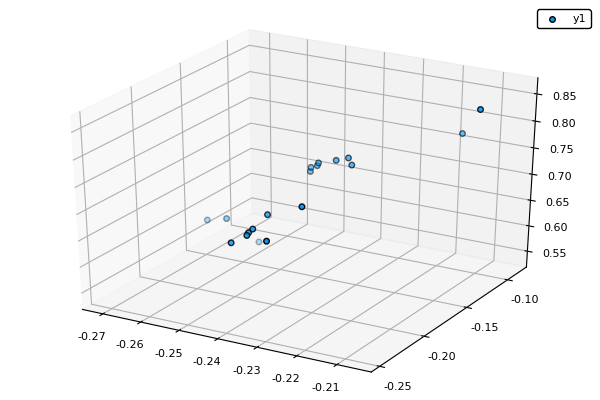

In [34]:
Plots.scatter(_3d_points[:,1], _3d_points[:,2], _3d_points[:,3])